In [233]:
# --- 0. Install necessary library ---
#changed as recommended approach (!pip)-->(%pip) which equals to: python -m pip install <module>
#%pip install gdown pandas numpy scikit-learn matplotlib seaborn

In [234]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # Keep for potential future use
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, precision_recall_fscore_support,f1_score, recall_score, accuracy_score
import gdown # Library to download from Google Drive
from sklearn.impute import SimpleImputer # Import imputer

# Define color codes
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
RESET = "\033[0m"  # Reset to default

#In here some data pre-procesing hyper-parameters that for simplicity is better to put up here, the rest are at the bottom within the main loop.
DATA_SCALED = True
DATA_MINORITY_CLASS_OVERSAMPLED = True

In [235]:

# --- 1. Download Data from Google Drive ---
if False:
    file_id = '1dRE9RSdR3pCnDbr5iYHfH2sdR4hOdG3H'
    output_file = 'synthetic_data_loaded_with_header.csv' # Changed filename for clarity
    url = f'https://drive.google.com/uc?id={file_id}'

    print(f"Downloading file from Google Drive (ID: {file_id})...")
    try:
        # Using fuzzy=True might help if the direct download link changes slightly
        gdown.download(url, output_file, quiet=False, fuzzy=True)
        print(f"File saved as {output_file}")
    except Exception as e:
        print(f"Failed to download file: {e}")
        exit()

In [236]:
#Alternativelly use the combined SECOM dataset csv in the dataset subfolder
# Define the dataset folder path (the files are in a subfolder called dataset)
from pathlib import Path
if True:
     dataset_folder = Path('dataset')
     dataset_filename= 'SECOM_combined_dataset.csv'

     print(f"Attempting to open the combined file {dataset_filename} saved locally in the folder {dataset_folder}")
     try:
          output_file = dataset_folder / dataset_filename
          print(f'File successfully opened.')
     except FileNotFoundError as e:
          print(f'File not found: {e}')
     except Exception as e:
          print(e)

Attempting to open the combined file SECOM_combined_dataset.csv saved locally in the folder dataset
File successfully opened.


In [237]:
# --- 2. Load Data using Pandas (Assuming Header IS Present) ---
try:
    # FIX: Remove header=None to let Pandas read the first row as header
    data = pd.read_csv(output_file)
    print(f"Data loaded successfully from {output_file} with shape: {data.shape}")
    # Display first few rows and info to check data types
    print("\nFirst 5 rows of loaded data:")
    print(data.head())
    print("\nData info:")
    data.info()
except Exception as e:
    print(f"Failed to load data from {output_file}: {e}")
    exit()

Data loaded successfully from dataset\SECOM_combined_dataset.csv with shape: (1567, 591)

First 5 rows of loaded data:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0    3030.93    2564.00  2187.7333  1411.1265     1.3602      100.0   
1    3095.78    2465.14  2230.4222  1463.6606     0.8294      100.0   
2    2932.61    2559.94  2186.4111  1698.0172     1.5102      100.0   
3    2988.72    2479.90  2199.0333   909.7926     1.3204      100.0   
4    3032.24    2502.87  2233.3667  1326.5200     1.5334      100.0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_581  feature_582  \
0    97.6133     0.1242     1.5005     0.0162  ...          NaN       0.5005   
1   102.3433     0.1247     1.4966    -0.0005  ...     208.2045       0.5019   
2    95.4878     0.1241     1.4436     0.0041  ...      82.8602       0.4958   
3   104.2367     0.1217     1.4882    -0.0124  ...      73.8432       0.4990   
4   100.3967     0.1235     1.5031    -0.0031  ...    

In [238]:
#Removing constant features form the dataset
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
def removeConstantFeatures(X_df):
    # Assuming X is a NumPy array or a DataFrame, and y is your target
    # If X is a DataFrame, you can also track column names
    is_dataframe = hasattr(X_df, 'columns')
    original_features = X_df.columns if is_dataframe else np.arange(X_df.shape[1])

    # Step 1: Remove constant features
    vt = VarianceThreshold(threshold=0.0)
    X_reduced = vt.fit_transform(X_df)

    # Identify kept and removed features
    kept_mask = vt.get_support()
    removed_features = original_features[~kept_mask]
    kept_features = original_features[kept_mask]

    # Convert to DataFrame if original was DataFrame
    X_cleaned_df = pd.DataFrame(X_reduced, columns=kept_features) if is_dataframe else X_reduced

    # Print message
    print(f"Removed {len(removed_features)} constant feature(s) from the original dataset:")
    print(list(removed_features))

    return X_cleaned_df


In [239]:
# --- 3. Prepare Data ---
if data.shape[1] > 1:
    # Assume last column is target 'y', all others are features 'X'
    feature_names = data.columns[:-1].tolist() # Get actual feature names from header
    X_df = data[feature_names] # Select feature columns using names
    y_series = data.iloc[:, -1] # Select target column by position

    X_df = removeConstantFeatures(X_df) #Removes constant features from the original dataset to avoid feeding non constribuiting features to the reducer
    #feature_names_after_removing_constant_features = X_df.columns

    #print(f"\nCurrent Feature names extracted from header: {feature_names[:5]}... (Total: {len(feature_names)})")
    print(f"\nKept Feature names: {X_df.columns[0:6].to_list()}... (Total: {len(X_df.columns)})")


    # --- Keep Robust Cleaning Steps ---
    # Convert non-numeric strings to numeric, coercing errors, otherwise-> NaN
    X_df_numeric = X_df.apply(pd.to_numeric, errors='coerce')
    y_series_numeric = pd.to_numeric(y_series, errors='coerce')

    # Handle potential NaN values resulting from coercion or missing values in original file
    imputer_X = SimpleImputer(strategy='mean')
    X_imputed = imputer_X.fit_transform(X_df_numeric)

    missing_labels_count = y_series_numeric.isna().sum()
    
    imputer_y = SimpleImputer(strategy='most_frequent') #changed strategy from mean to most frequent since we have binary labels
    y_imputed = imputer_y.fit_transform(y_series_numeric.values.reshape(-1, 1)).flatten()

    # Check for NaNs after imputation (should only happen if a whole column was non-numeric/NaN)
    if np.isnan(X_imputed).any() or np.isnan(y_imputed).any():
        print("Warning: NaNs still present after imputation. Check columns with all invalid values.")
        # Consider more advanced imputation or dropping problematic columns/rows if this occurs

    X = X_imputed
    y = y_imputed

    print(f"Features shape after cleaning: {X.shape}")
    
    print(f"Number of missing labels to be imputed: {missing_labels_count}")

    # TO CHANGE -1 LABELS TO 0 !!!!!!!!!
    #y = np.where(y == -1, 0, y)


    print(f"Target shape after cleaning: {y.shape}")
    n_features_loaded = X.shape[1] # Keep track of the number of features

else:
    print("Error: Loaded data has only one column. Cannot separate features and target.")
    exit()

Removed 116 constant feature(s) from the original dataset:
['feature_5', 'feature_13', 'feature_42', 'feature_49', 'feature_52', 'feature_69', 'feature_97', 'feature_141', 'feature_149', 'feature_178', 'feature_179', 'feature_186', 'feature_189', 'feature_190', 'feature_191', 'feature_192', 'feature_193', 'feature_194', 'feature_226', 'feature_229', 'feature_230', 'feature_231', 'feature_232', 'feature_233', 'feature_234', 'feature_235', 'feature_236', 'feature_237', 'feature_240', 'feature_241', 'feature_242', 'feature_243', 'feature_256', 'feature_257', 'feature_258', 'feature_259', 'feature_260', 'feature_261', 'feature_262', 'feature_263', 'feature_264', 'feature_265', 'feature_266', 'feature_276', 'feature_284', 'feature_313', 'feature_314', 'feature_315', 'feature_322', 'feature_325', 'feature_326', 'feature_327', 'feature_328', 'feature_329', 'feature_330', 'feature_364', 'feature_369', 'feature_370', 'feature_371', 'feature_372', 'feature_373', 'feature_374', 'feature_375', 'fe

In [240]:

# --- 4. Split Data for Fitness Evaluation ---
# Using the cleaned X and y, with stratify helps maintain the proportion of class labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
n_features = X_train.shape[1] # Use the actual number of features

# Map -1 → 0, 1 → 1
y_train = np.where(y_train == -1, 0, y_train)
y_val = np.where(y_val == -1, 0, y_val)

print(f"\nTraining features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f'Unique values in original labels: {np.unique(y)}')
print(f'Unique values in training labels after mapping negative class (-1) to 0: {np.unique(y_train)}')
print(f'Unique values in validation labels after mapping negative class (-1) to 0: {np.unique(y_val)}')


Training features shape: (1096, 474)
Validation features shape: (471, 474)
Unique values in original labels: [-1  1]
Unique values in training labels after mapping negative class (-1) to 0: [0 1]
Unique values in validation labels after mapping negative class (-1) to 0: [0 1]


In [241]:
from imblearn.over_sampling import SMOTE

# 2. Feature scaling (optional but often helps RF slightly)
if DATA_SCALED:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

# 3. SMOTE oversampling (only on train set!)
if DATA_MINORITY_CLASS_OVERSAMPLED:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

In [242]:
#To visualize the distribution of the labels, in the case of SECOM is imbalanced
def plotLabelsDistribution(label_array, data_name='default_name'):
    data = pd.DataFrame({'label': label_array})

    # Count the occurrences of each class
    class_counts = data['label'].value_counts().sort_index()
    class_percentages = class_counts / class_counts.sum() * 100

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(6,4))
    #sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis", hue=class_counts, legend=False)

    plt.title(f'Class Distribution for {data_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Annotate counts and percentages on bars
    for i, (count, perc) in enumerate(zip(class_counts.values, class_percentages.values)):
        plt.text(i, count + max(class_counts.values)*0.01, f'{count} ({perc:.1f}%)', 
                ha='center', va='bottom', fontsize=10)

    plt.show()


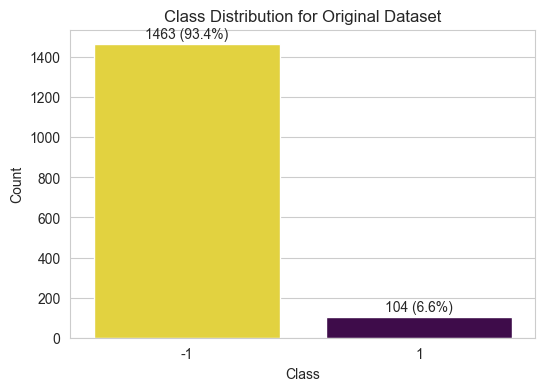

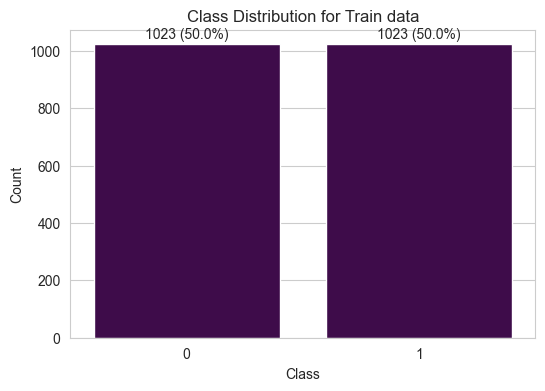

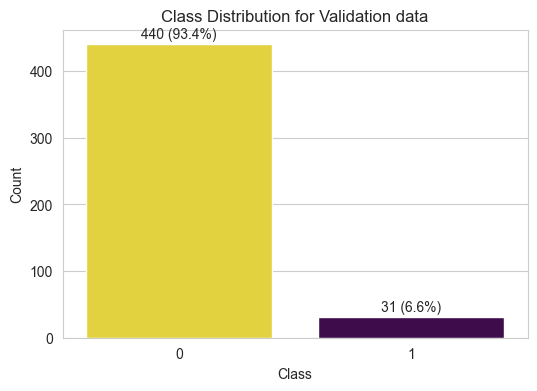

In [243]:
#plot LAbel distributions
plotLabelsDistribution(y,'Original Dataset')
plotLabelsDistribution(y_train,'Train data')
plotLabelsDistribution(y_val,'Validation data')

In [244]:
# --- Fitness Function (using Random Forest) ---
def fitness_function(individual, model, penalty_coef, num_desired_features, threshold=0.5, classif_report=False):
    individual = np.array(individual)  #Ensure it's a NumPy array
    selected_indices = np.where(individual == 1)[0] # Get indices where bit is 1
    num_selected_features = len(selected_indices)

    #TODO: This validation can be done before calling this function!!!!!!!!!
    if num_selected_features == 0:
        return -np.inf # Heavily penalize empty feature set

    # Select corresponding columns from train/validation sets
    X_train_sel = X_train[:, selected_indices]
    X_val_sel = X_val[:, selected_indices]
    
    try:        
        model.fit(X_train_sel, y_train)
        #y_pred = model.predict(X_val_sel)

        # 5. Predict probabilities
        y_probs = model.predict_proba(X_val_sel)[:, 1]
        # 6. Threshold tuning (try 0.2 instead of default 0.5)        
        y_pred = (y_probs > threshold).astype(int)

        # 7. Evaluate
        if classif_report:
            print(classification_report(y_val, y_pred, digits=4, zero_division=0))
            #print("F1-score:", f1_score(y_val, y_pred))        

        #f1 score more suitable for imbalanced (binary) datsaet
        #penalty discourages solutions that are significantly larger or smaller than the target subset size 
        #score = accuracy_score(y_val,y_pred)
        score = f1_score(y_val,y_pred,average='binary', pos_label=1)
        penalty = penalty_coef*abs(num_selected_features - num_desired_features)
        
        fitness = score - penalty

    except ValueError as e:
        # Catch potential errors during fitting/prediction if data issues remain
        print(f"Error during model fitting/prediction: {e}")
        fitness = -np.inf # Penalize if model fails
    return fitness

In [245]:
#Evaluate fitness population in parallel and saves each new pair individual,fitness in cache, population is pre-filtered
#so only individuals not in the cache are actually calculated
#could be improved if saved to disk, but then must review dataset splitting process.
from joblib import Parallel, delayed

def evaluate_population(num_desired_features, population, classif_model, penalty, fitness_cache=None, n_jobs=-1, batch_size="auto", classif_treshold=0.5):
    print(f'\tEvaluating population fitness in parallel (batch_size={batch_size}) with a classification threshold = {classif_treshold}..')

    if fitness_cache is None:
        fitness_cache = {}

    #print(f'Population shape when entering {evaluate_population.__name__} is {population.shape}: ')
    # Convert individuals to hashable keys
    keys = [tuple(ind) for ind in population]

    # Find unique individuals that still need evaluation
    unique_to_eval = list(set(k for k in keys if k not in fitness_cache))

    print(f"\tThere are {len(unique_to_eval)} new individuals to evaluate (cached: {len(keys) - len(unique_to_eval)})")

    # Parallel evaluation only on new individuals
    new_fitnesses = Parallel(n_jobs=n_jobs, batch_size=batch_size)(
        delayed(fitness_function)(list(ind), classif_model, penalty, num_desired_features, classif_treshold) 
        for ind in unique_to_eval
    )

    # Update cache
    for k, fit in zip(unique_to_eval, new_fitnesses):
        fitness_cache[k] = fit

    # Build final fitness array corresponding to input population
    fitness_list  = [fitness_cache[k] for k in keys] #<----previous result if it breaks just return this instead of the df

    #Build DataFrame so later be easier to order individuals per fitness, but must maintain the other code.
    df_fitness_individuals = pd.DataFrame({
        'fitness': fitness_list ,
        'bits': [np.array(ind) for ind in keys]  # convert individuals back to np.array
    })
    #do NOT change the order of the df_fitness at this point IMPORTANT!!!!, leave it for the next step!!
    #df_fitness_individuals = df_fitness_individuals.sort_values(by='fitness', ascending=False).reset_index(drop=True)
    return df_fitness_individuals, fitness_cache


In [246]:
#The expected number of selected features is d ⊆ n_features, this constraint must be set up since the first population
# to make more likely for the algorithm to focus on small subsets instead of larger ones in further generations.
#We set the chance of each gene being 1 in the initial population P to a value of d/D
def initialize_population(d, pop_size, n_features):
    probability_for_1 = d/n_features
    probability_for_0 = 1 - probability_for_1    
    
    print(f'-Building Initial population of size: {pop_size} with approximately {d} features per individual from a max of {n_features}')
    
    pop = np.random.choice([0, 1], size=(pop_size, n_features), p=[probability_for_0, probability_for_1])    
    
    # Ensure initial individuals are not all zeros
    for i in range(pop_size):
        if not pop[i].any:
            #then randomly sets one feature to 1.
            pop[i, np.random.randint(0, n_features)] = 1
    return pop

#TEST:
if False:
    print(f'TESTING:---------')
    pop_test = initialize_population(5, 10, 10)
    print(f'output shape:{pop_test.shape}')
    print(f'output:{pop_test}')

In [247]:
#Returns array of len(pop) individuals each one is selected by tournament
#Each tournament round is won by the individual with the higest fitness and that winner goes to the result
def tournament_selection(pop, fitnesses, k=3):
    # Handle potential -inf fitness values gracefully
    valid_indices = np.where(np.isfinite(fitnesses))[0]
    if len(valid_indices) == 0:
        # If no individuals have valid fitness, return random individuals to avoid crash
        print("Warning: No individuals with valid fitness in selection.")
        return pop[np.random.choice(len(pop), size=len(pop))]
    if len(valid_indices) < k:
        # If fewer valid individuals than tournament size, select randomly from valid ones
        selected_idx = np.random.choice(valid_indices, size=len(pop), replace=True) # Allow replacement
        return pop[selected_idx]

    selected = []
    for _ in range(len(pop)):
       # Ensure tournament participants are chosen only from valid individuals
       tournament_contenders_indices = np.random.choice(valid_indices, k, replace=False)
       winner_idx_in_contenders = np.argmax(fitnesses[tournament_contenders_indices])
       winner_original_idx = tournament_contenders_indices[winner_idx_in_contenders]
       selected.append(pop[winner_original_idx])
    return np.array(selected)

In [248]:
def keepBestFitnessRecord(gen, valid_fitness_indices, fitnesses, population, best_individual_overall, best_fit_overall, best_fitnesses, features_selected_history):
    
    if len(valid_fitness_indices) > 0:         
        gen_best_idx_among_valid = np.argmax(fitnesses[valid_fitness_indices])
        gen_best_original_idx = valid_fitness_indices[gen_best_idx_among_valid]
        gen_best_fitness = fitnesses[gen_best_original_idx]

        # Update overall best
        if gen_best_fitness > best_fit_overall:
            best_fit_overall = gen_best_fitness
            best_individual_overall = population[gen_best_original_idx].copy()

        # Store history based on overall best
        best_fitnesses.append(best_fit_overall)
        features_selected_history.append(np.sum(best_individual_overall) if best_individual_overall is not None else 0)

        #print(f'\tBest Fitness: {best_fitnesses}')
    elif len(valid_fitness_indices) == 0:
        #"Warning: No valid individuals in generation it should be Stopping early the GA loop
        # Keep the last known best if available, otherwise end with None
        best_fitnesses.append(best_fit_overall if np.isfinite(best_fit_overall) else np.nan)
        features_selected_history.append(np.sum(best_individual_overall) if best_individual_overall is not None else 0)
    
    return best_individual_overall, best_fit_overall, best_fitnesses, features_selected_history

ELITISM:

CROSSOVER & MUTATION:

In [249]:
# Crossover & Mutation ORIGINALS
def crossoverAndMutation_Original(population, pop_size,selected_parents, crossover_rate, mutation_rate):
    offspring = np.empty_like(population)
    for i in range(0, pop_size, 2): # Uses tuned POP_SIZE
        p1_idx, p2_idx = i, (i + 1) % pop_size
        parent1, parent2 = selected_parents[p1_idx], selected_parents[p2_idx]
        if np.random.rand() < crossover_rate:
            child1 = uniform_crossover(parent1, parent2)
            child2 = uniform_crossover(parent2, parent1)
        else:
            child1, child2 = parent1.copy(), parent2.copy()
        offspring[i] = mutate(child1, mutation_rate)
        if i + 1 < pop_size:
            offspring[i+1] = mutate(child2, mutation_rate)
    return offspring

def uniform_crossover(parent1, parent2):
    mask = np.random.randint(0, 2, size=len(parent1), dtype=bool)
    child = np.where(mask, parent1, parent2)
    return child

def mutate(individual, mutation_rate):
    mutant = individual.copy()
    mutation_mask = np.random.rand(len(mutant)) < mutation_rate
    mutant[mutation_mask] = 1 - mutant[mutation_mask] # Flip bits
    # Ensure mutation doesn't result in an all-zero individual
    if np.sum(mutant) == 0 and len(mutant) > 0:
         mutant[np.random.randint(0, len(mutant))] = 1
    return mutant

In [250]:
import numpy as np

def m_point_crossover(population, selected_pairs, m):
    """
    Apply m-point crossover to selected parent pairs in a vectorized way.

    Args:
        population (np.ndarray): Full population, shape (pop_size, chromosome_length)
        selected_pairs (np.ndarray): Array of selected parent indexes, shape (num_pairs, 2)
        m (int): Number of crossover points (must be >=1)

    Returns:
        offspring1, offspring2 (np.ndarray): Two offspring populations (shape: num_pairs x chromosome_length)
    """
    #print(f'Population shape when entering m_point_crossovder: {population.shape}')
    #print(f'Selected  pairs shape when entering m_point_crossovder: {selected_pairs.shape}')

    num_pairs = selected_pairs.shape[0]
    chrom_length = population.shape[1]
    
    assert m >= 1, "Number of crossover points must be at least 1"
    assert m < chrom_length, "Number of crossover points must be less than chromosome length"
    
    # Extract the selected parent chromosomes
    parents1 = population[selected_pairs[:, 0]]
    parents2 = population[selected_pairs[:, 1]]
    
    # Generate random cutting points for each pair
    cuts = np.sort(
        np.random.randint(1, chrom_length, size=(num_pairs, m)),
        axis=1
    )
    
    # Initialize offspring arrays
    offspring1 = np.empty_like(parents1)
    offspring2 = np.empty_like(parents2)
    
    pos = np.arange(chrom_length)   #[0,1,2,..]
    
    for i in range(num_pairs):
        seg = np.zeros(chrom_length, dtype=int) #segments array zero
        #print(f'cut points: {cuts[i]}') #<<-- print when testing!!!!!!!
        for cut in cuts[i]:
            seg[pos >= cut] += 1            
        # Alternate segments: even segments from parent1, odd from parent2
        mask = seg % 2 == 0
        offspring1[i] = np.where(mask, parents1[i], parents2[i])
        offspring2[i] = np.where(mask, parents2[i], parents1[i])

    return offspring1, offspring2

#TEST:-------------Remember to enable line for printing cut points!
if False:
    num_pairs = 1
    selected_indexes = np.zeros((num_pairs, 2), dtype=int)
    selected_indexes[0] = [0,1]
    #selected_indexes[1] = [2,3]

    print(f'TESTING:---------')
    pop_test = initialize_population(10, 10, 20)
    print(f'output shape:{pop_test.shape}')
    print(f'output:\n{pop_test[0:2]}')

    offspring1, offspring2 = m_point_crossover(pop_test,selected_indexes,3)
    print(f'child1:\n{offspring1} \n child2:\n{offspring2}')

In [251]:
# Crossover & Mutation as on the Paper vectorized to process the entire population
def controlled_mutation_population(population, mutation_rate):
    """
    Apply controlled mutation to an entire population.    
    Scaling p0 using the ratio n1 / n0 makes sure that, on average, 
    the number of genes flipping from 1 → 0 and from 0 → 1 is similar.
	So, the total number of selected items (1s) stays roughly constant, even after mutation.
    population: shape (num_individuals, num_genes), with 0s and 1s
    mutation_rate: base mutation rate (e.g., 0.01)    
    """
    mutant_pop = population.copy()

    # Sum number of 0s and 1s for each individual (along axis=1)
    n0 = np.sum(mutant_pop == 0, axis=1, keepdims=True)  # shape (num_individuals, 1)
    n1 = np.sum(mutant_pop == 1, axis=1, keepdims=True)

    # Avoid division by zero
    n0_safe = np.where(n0 == 0, 1, n0)

    p1 = mutation_rate  # 1 → 0
    p0 = mutation_rate * (n1 / n0_safe)  # 0 → 1

    # Generate random values for all genes in all individuals
    random_vals = np.random.rand(*mutant_pop.shape)

    # Create masks
    mask1 = (mutant_pop == 1) & (random_vals < p1)  # flip 1 → 0
    mask0 = (mutant_pop == 0) & (random_vals < p0)  # flip 0 → 1

    # Apply mutation
    mutant_pop[mask1] = 0
    mutant_pop[mask0] = 1

    # Ensure no individual becomes all-zero
    sums = np.sum(mutant_pop, axis=1)
    zero_inds = np.where(sums == 0)[0]
    for idx in zero_inds:
        gene_idx = np.random.randint(0, mutant_pop.shape[1])
        mutant_pop[idx, gene_idx] = 1

    return mutant_pop

SELECTION MECHANISM

In [252]:
import numpy as np
import pandas as pd

def rank_based_selection(df, q, num_pairs):
    """
    Selects pairs of parents using rank-based roulette wheel selection.

    Parameters:
    - df: DataFrame sorted by fitness descending. IMPORTANT!!!
    - q: Selection pressure parameter (0 < q < 1).
    - num_pairs: Number of parent pairs to select.

    Returns:
    - NumPy array of shape (num_pairs, 2) with selected parent indexes.
    """
    n = len(df)
    
    # Step 1: Calculate selection probabilities using P(i) = q * (1 - q)^(i - 1)
    P = np.array([q * (1 - q) ** i for i in range(n)])  # i from 0 to n-1
    
    # Calculate cumulative probabilities p_i
    cumulative_probs = np.cumsum(P)
    
    selected_indexes = np.zeros((num_pairs, 2), dtype=int)
    
    for pair_idx in range(num_pairs):
        for parent_idx in range(2):  # select two parents per pair
            r = np.random.uniform(0, cumulative_probs[-1])
            i = np.searchsorted(cumulative_probs, r)
            selected_indexes[pair_idx, parent_idx] = i
    
    return selected_indexes

#TEsting:
#population_test = initialize_population(d_features=30, pop_size=100, n_features=n_features)

In [253]:
#To implement steady state control:
# If the (mutated) chromosome is superior to both parents, it replaces the similar parent; if it is in between the two
#parents, it replaces the inferior parent; otherwise, the most inferior chromosome in the population is replaced. 
def steady_state_control(df_offspring_fitness, df_current_population, selected_pairs, one_replacement_per_generation=True):
 
    # Always force bits to 2D int numpy array
    population_np = np.vstack(df_current_population['bits'].apply(lambda x: np.array(x, dtype=int)).to_numpy())    
    
    # Convert population bits to list-of-arrays for safe matching
    current_pop_bits = [np.array(ind, dtype=int) for ind in population_np]
    #print(f'Population as list of arrays:\n {current_pop_bits[0:2]}\n') #for testing

    eliminated_parents_cache = {}   #The parents eliminated from the population go in here
# The new population is first initialized with the current population
    new_population_bits = current_pop_bits.copy()
    df_new_population = df_current_population.copy()

    # Go through offspring one by one
    for i, offspring_bits in enumerate(df_offspring_fitness['bits'].apply(lambda x: np.array(x, dtype=int))):
        offspring_fitness = df_offspring_fitness.iloc[i]['fitness']

        # Find parents
        pair_idx = i // 2  # 2 offspring per pair
        parent1_bits = population_np[selected_pairs[pair_idx][0]]
        parent2_bits = population_np[selected_pairs[pair_idx][1]]

        # Parent fitness lookup
        parent1_fitness = df_current_population[
            df_current_population['bits'].apply(lambda x: np.array_equal(np.array(x, dtype=int), parent1_bits))
        ].iloc[0]['fitness']
        parent2_fitness = df_current_population[
            df_current_population['bits'].apply(lambda x: np.array_equal(np.array(x, dtype=int), parent2_bits))
        ].iloc[0]['fitness']

        print(f'{i} - Parent1 fitness: {parent1_fitness}\t PArent2 fitness: {parent2_fitness}')

        if True:
            # Decide replacement (target bits: the bits that matches thos of the individual to be replaced)
            if offspring_fitness > max(parent1_fitness, parent2_fitness):
                target_bits = parent1_bits if parent1_fitness < parent2_fitness else parent2_bits
            elif min(parent1_fitness, parent2_fitness) < offspring_fitness <= max(parent1_fitness, parent2_fitness):
                target_bits = parent1_bits if parent1_fitness < parent2_fitness else parent2_bits
            else:
                worst_idx = df_new_population['fitness'].idxmin()
                target_bits = np.array(df_new_population.iloc[worst_idx]['bits'], dtype=int)

            # Debugging
            #print("Target bits:", target_bits)
            #print("Target bits dtype:", target_bits.dtype, "shape:", target_bits.shape)


            # Find index to replace safely
            found = False
            for idx, bits in enumerate(new_population_bits):
                #print(f"Checking idx {idx}: dtype {np.array(bits).dtype} shape {np.array(bits).shape}")
                if np.array_equal(bits, target_bits):
                    replace_idx = idx
                    found = True
                    break

            if not found:
                raise ValueError("Replacement failed: No matching bits found.")

            new_population_bits[replace_idx] = offspring_bits
            df_new_population.at[replace_idx, 'fitness'] = offspring_fitness
            df_new_population.at[replace_idx, 'bits'] = offspring_bits.tolist()
            
            #adds the bits of the parent eliminated from new population, so for the next offspring with this same father an action must be taken
            eliminated_parents_cache[tuple(target_bits)] = target_bits 
            
            #If update one chromosome on each generation is selected:
            if found and one_replacement_per_generation: break
    
    df_offspring = df_new_population.copy()
    #To keep it sorted by fitness descending IMPORTANT!!!
    df_offspring = df_offspring.sort_values(by='fitness', ascending=False).reset_index(drop=True)
    #print(f'\df_offspring:\n{df_offspring["fitness"]}')
    return df_offspring


In [254]:
def control_genetic_operations(
    selected_pairs, m_crossover, mutation_rate, df_current_population, d_features,
    classif_model, penalty, fitness_cache, one_replacement_per_generation=True,
    strategy='generational', classif_treshold=0.5):
    """
    Controls genetic operations using steady-state or generational strategy.
    Returns:
        df_offspring: DataFrame same shape as df_fitness_individuals
    """
    #print(f'(1) df_current_population shape calculated when entering {control_genetic_operations.__name__} is {df_current_population.shape}: ')
     # Always force bits to 2D int numpy array
    population = np.vstack(df_current_population['bits'].apply(lambda x: np.array(x, dtype=int)).to_numpy())
    #print(f'(2) Population shape calculated when entering {control_genetic_operations.__name__} is {population.shape}: ')

    # 1. Apply crossover
    offspring1, offspring2 = m_point_crossover(population, selected_pairs, m_crossover)
    offspring_pop = np.vstack((offspring1, offspring2))

    # 2. Apply mutation
    #print(f'Offspring population len before applying mutation: {offspring_pop.shape}')
    offspring_pop = controlled_mutation_population(offspring_pop, mutation_rate)

    #print(f'(3) Fitness cache len from inside {control_genetic_operations.__name__} is {len(fitness_cache)}: ')
    # 3. Evaluate offspring
    df_offspring_fitness, fitness_cache = evaluate_population(
        d_features, offspring_pop, classif_model, penalty, fitness_cache, n_jobs=-1, batch_size="auto", classif_treshold=classif_treshold
    )
    #print(f'(4) Fitness cache shape len inside {control_genetic_operations.__name__} after evaluate_population is {len(fitness_cache)}: ')
  

    if strategy == 'generational':
        # Replace entire population with offspring
        df_offspring = df_offspring_fitness.copy()

    elif strategy == 'steady_state':        
        df_offspring = steady_state_control(df_offspring_fitness, df_current_population, 
                                            selected_pairs, one_replacement_per_generation)
    else:
        raise ValueError("Unknown strategy. Use 'generational' or 'steady_state'")
    
    #To keep it sorted by fitness descending IMPORTANT!!!
    df_offspring = df_offspring.sort_values(by='fitness', ascending=False).reset_index(drop=True)
    return df_offspring, fitness_cache


In [255]:
#For keep record of the best individuals of each experiment and later save to disk
from bestracker import BestTracker
def resultsTrackerFunction(results_tracker:BestTracker, current_best_fitness, current_best_individual, 
                        current_best_number_of_features, generation, crossover_operator_point, 
                        mutation_coef, population_size, selection_coef, strategy, expectedFitness, 
                        classif_model, goal_features_number, penalty_coef, num_elite, crossover_rate,
                        max_gen, best_individual_overall, classif_threshold, data_scaled, minority_class_oversampled):
    
    results_tracker.update(
        fitness= current_best_fitness,
        features= current_best_individual,
        number_of_features= current_best_number_of_features,
        generation= generation,
        selection_coef= selection_coef,
        crossover_operator_point= crossover_operator_point,
        crossover_rate= crossover_rate,
        mutation_coef= mutation_coef,
        penalty_coef= penalty_coef,
        population_size= population_size,
        strategy= strategy,
        num_elite= num_elite,
        expectedFitness= expectedFitness,
        classif_model= classif_model,
        goal_features_number= goal_features_number,
        max_gen= max_gen,
        classif_threshold = classif_threshold,
        data_scaled = data_scaled,
        minority_class_oversampled=minority_class_oversampled
    )

    #If the current fitness is greater than the overall so far, updates.
    if (best_individual_overall is None) or (current_best_fitness > best_individual_overall['fitness']):
        best_individual_overall = {
            'fitness': current_best_fitness,
            'features': current_best_individual,
            'number_of_features': current_best_number_of_features,
            'generation': generation
        }

    return best_individual_overall

In [256]:
def getBestIndividual(best_individual_overall, df_current_population, results_tracker, gen, m_crossover, MUTATION_RATE, POP_SIZE, 
                        q, strategy, expectedFitness, model, DESIRED_FEATURES_NUMBER, PENALTY_COEFF,
                        N_ELITE, CROSSOVER_RATE, N_GEN,classification_threshold, data_scaled, minority_class_oversampled, best_solutions_per_gen_history):
    
    current_best_fitness = df_current_population['fitness'].iloc[0]
    current_best_individual= np.array(df_current_population['bits'].iloc[0], dtype=int)
    current_best_number_of_features = np.sum(current_best_individual)
    best_individual_overall = resultsTrackerFunction(results_tracker, current_best_fitness, current_best_individual, 
                        current_best_number_of_features, gen, m_crossover, MUTATION_RATE, POP_SIZE, q, strategy,
                        expectedFitness, model, DESIRED_FEATURES_NUMBER, PENALTY_COEFF, N_ELITE, CROSSOVER_RATE, N_GEN,
                        best_individual_overall, classification_threshold, data_scaled, minority_class_oversampled)
    
    # Store history of each generation best fitness and number of features
    best_solutions_per_gen_history.append((current_best_fitness,current_best_number_of_features))

    print(f"{GREEN}Current Population: {gen}/{N_GEN}:{RESET} {YELLOW}Best Current Fitness = {current_best_fitness:.4f}{RESET}, {BLUE}With Features Selected = {current_best_number_of_features}{RESET}")
    print('-'*30)
    return best_solutions_per_gen_history, best_individual_overall

Working version

In [ ]:
# GA Parameters (TUNED for potentially faster runtime)
POP_SIZE = 50 
N_GEN = 100    
#CROSSOVER_RATE = 1 # Kept the same - Not used in paper research apparently
MUTATION_RATE = 0.1  
#ELITISM = False       # Kept the same
#N_ELITE = 1          # Kept the same
#LOCAL_SEARCH_STEPS = 1 # Reduced from 5
#LS_TOP_K = 2          # Reduced from 3
PENALTY_COEFF = 0.001   
DESIRED_FEATURES_NUMBER = 50

# DEfine the Classifier model: Random Forest
# Use fewer estimators for significantly faster fitness evaluation
model = RandomForestClassifier(class_weight=None, #'balanced'only when imbalanced, #n_estimators=400, # Reduced from 50
                                random_state=42,
                                n_jobs=-1) # Use n_jobs=-1 for parallelization
#memoization: cache for pairs: individual,fitness to avoid recalculations
fitness_cache = {}
best_solutions_per_gen_history = []
best_individual_overall = None
best_fit_overall = -np.inf
features_selected_history = []

gen=0
q=0.7 #roulette-wheel selection coeficient
m_crossover=3   #crossover operator points
#strategy = "steady_state"  #-->TODO: To improve
strategy = "generational"
one_replacement_per_generation = True #Applies If steady state is selected
expectedFitness = 1.0
classification_threshold = 0.3
parents_pairs = int(POP_SIZE/2)
results_tracker = BestTracker() #for keeping track of best fitness per generation on a file

initial_population = initialize_population(DESIRED_FEATURES_NUMBER, POP_SIZE, n_features=n_features)
print("\nStarting Hybrid Genetic Algorithm TESTªªª...")
print(f'df_offspring with a {strategy} strategy')
print(f'\tEvaluating Initial population fitness..')
df_current_population, fitness_cache = evaluate_population(DESIRED_FEATURES_NUMBER, population=initial_population, classif_model=model, penalty=PENALTY_COEFF, fitness_cache=fitness_cache, n_jobs=-1, batch_size= "auto", classif_treshold=classification_threshold)      
#order by fitness desc
df_current_population = df_current_population.sort_values(by='fitness', ascending=False).reset_index(drop=True)
best_solutions_per_gen_history, best_individual_overall = getBestIndividual(best_individual_overall, df_current_population, results_tracker, gen, m_crossover, MUTATION_RATE, POP_SIZE, q, strategy, expectedFitness,
                                                                    model, DESIRED_FEATURES_NUMBER, PENALTY_COEFF, N_ELITE, CROSSOVER_RATE, N_GEN,  classification_threshold, DATA_SCALED, DATA_MINORITY_CLASS_OVERSAMPLED, best_solutions_per_gen_history)
#--------------------------------------------------------------------------------------------------------
#For debugging:--------------------------------------------------------------------
#print(f'\tfitnesses[valid_fitness_indices]: {fitnesses[valid_fitness_indices]}')
#print(f'\tBest Fitness: {best_fitnesses}')  
#print(f'\ndf_fitness:\n {df_current_population}')
#----------------------------------------------------------------------------------      
gen = 1
while  (best_solutions_per_gen_history[-1][0] <= expectedFitness) and (gen <= N_GEN) :
    #--- GA Operators (Selection, Crossover, Mutation) ---
    selected_parents_test = rank_based_selection(df_current_population, q, parents_pairs)    

    df_offspring, fitness_cache =control_genetic_operations(selected_parents_test, m_crossover, MUTATION_RATE, df_current_population, DESIRED_FEATURES_NUMBER,
                                model, PENALTY_COEFF, fitness_cache, one_replacement_per_generation, strategy, classif_treshold=classification_threshold)
    #replacement of the current population for the offspring
    df_current_population = df_offspring
    best_solutions_per_gen_history, best_individual_overall = getBestIndividual(best_individual_overall, df_current_population, results_tracker, gen, m_crossover, MUTATION_RATE, POP_SIZE, q, strategy, expectedFitness,
                                                                        model, DESIRED_FEATURES_NUMBER, PENALTY_COEFF, N_ELITE, CROSSOVER_RATE, N_GEN,  classification_threshold, DATA_SCALED, DATA_MINORITY_CLASS_OVERSAMPLED, best_solutions_per_gen_history)
    gen = gen +1

print("Hybrid Genetic Algorithm finished.")
print(f'Best solution found--> fitness: {best_individual_overall['fitness']:.4f}, Number of features:{best_individual_overall['number_of_features']} at generation: {best_individual_overall['generation']}')
#return best_individual_overall, best_fitnesses, features_selected_history, fitness_cache
#Save experiment resuls to disk
results_tracker.save()

-Building Initial population of size: 50 with approximately 50 features per individual from a max of 474

Starting Hybrid Genetic Algorithm TESTªªª...
df_offspring with a generational strategy
	Evaluating Initial population fitness..
	Evaluating population fitness in parallel (batch_size=auto) with a classification threshold = 0.3..
	There are 50 new individuals to evaluate (cached: 0)
Current Population: 0/100: Best Current Fitness = 0.2969, With Features Selected = 49
------------------------------
	Evaluating population fitness in parallel (batch_size=auto) with a classification threshold = 0.3..
	There are 50 new individuals to evaluate (cached: 0)
Current Population: 1/100: Best Current Fitness = 0.3437, With Features Selected = 52
------------------------------
	Evaluating population fitness in parallel (batch_size=auto) with a classification threshold = 0.3..
	There are 50 new individuals to evaluate (cached: 0)
Current Population: 2/100: Best Current Fitness = 0.3561, With Feat

In [258]:
print(f'\nReport for the Best solution found with fitness: {fitness_function(best_individual_overall['features'], model, PENALTY_COEFF, DESIRED_FEATURES_NUMBER, classification_threshold, classif_report=True)}')


              precision    recall  f1-score   support

           0     0.9743    0.9477    0.9608       440
           1     0.4651    0.6452    0.5405        31

    accuracy                         0.9278       471
   macro avg     0.7197    0.7964    0.7507       471
weighted avg     0.9408    0.9278    0.9332       471


Report for the Best solution found with fitness: 0.5165405405405405


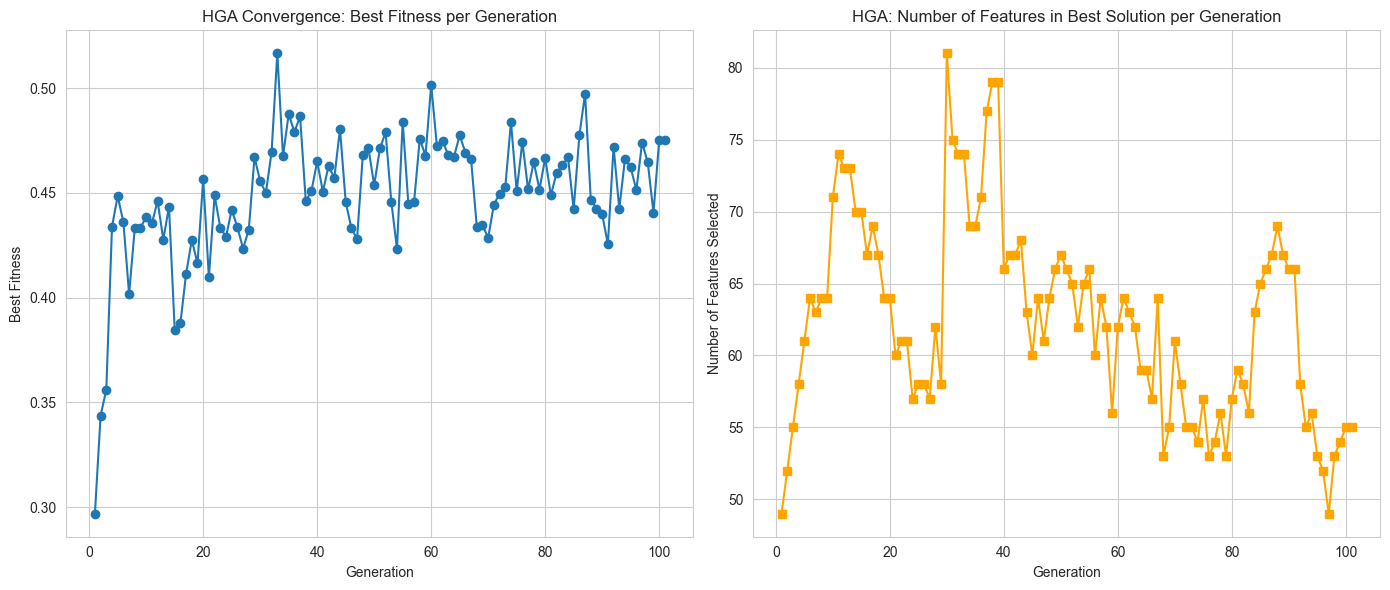

In [259]:

# --- 8. Plot Fitness Curve and Number of Features Selected ---
fitness_history,features_selected_history = zip(*best_solutions_per_gen_history)
if fitness_history and features_selected_history:
    generations = range(1, len(fitness_history) + 1)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(generations, fitness_history, marker='o', linestyle='-')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.title('HGA Convergence: Best Fitness per Generation')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(generations, features_selected_history, marker='s', linestyle='-', color='orange')
    plt.xlabel('Generation')
    plt.ylabel('Number of Features Selected')
    plt.title('HGA: Number of Features in Best Solution per Generation')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot results as no valid solution was found or history is empty.")


In [260]:
if False:
    #TESTING-------------
    gen=0
    initial_population = initialize_population(DESIRED_FEATURES_NUMBER, POP_SIZE, n_features=n_features)
    print("\nStarting Hybrid Genetic Algorithm TESTªªª...")
    print(f'df_offspring with a {strategy} strategy')
    print(f'\tEvaluating Initial population fitness..')
    df_current_population, fitness_cache = evaluate_population(DESIRED_FEATURES_NUMBER, population=initial_population, classif_model=model, penalty=PENALTY_COEFF, fitness_cache=fitness_cache, n_jobs=-1, batch_size="auto")      
    #order by fitness desc
    df_current_population = df_current_population.sort_values(by='fitness', ascending=False).reset_index(drop=True)
    current_best_fitness = df_current_population['fitness'].iloc[0]
    current_best_individual= np.array(df_current_population['bits'].iloc[0], dtype=int)
    current_best_number_of_features = np.sum(current_best_individual)

    print(f"{GREEN}Initial Population: {gen}/{N_GEN}:{RESET} {YELLOW}Best Current Fitness = {current_best_fitness:.4f}{RESET}, {BLUE}With Features Selected = {current_best_number_of_features}{RESET}")
    # THE LOOP WOULD START AROUND HERE
    gen = 1

    #print(f'Population as in df:\n {df_current_population['bits']}')

    #--- GA Operators (Selection, Crossover, Mutation) ---
    selected_parents_test = rank_based_selection(df_current_population, q, parents_pairs)    

    # Always force bits to 2D int numpy array
    population_np = np.vstack(df_current_population['bits'].apply(lambda x: np.array(x, dtype=int)).to_numpy())
    #print(f'Population in 2D int numpy array:\n {population_np[0:5]}')
    print(f'df_current_population fitness:\n{df_current_population["fitness"]}')

    # 1. Apply crossover
    offspring1, offspring2 = m_point_crossover(population_np, selected_parents_test, m_crossover)
    offspring_pop = np.vstack((offspring1, offspring2))

    # 2. Apply mutation
    offspring_pop = controlled_mutation_population(offspring_pop, MUTATION_RATE)

    # 3. Evaluate offspring
    df_offspring_fitness, fitness_cache = evaluate_population( DESIRED_FEATURES_NUMBER, offspring_pop, model, PENALTY_COEFF, fitness_cache, n_jobs=-1, batch_size="auto")
    print(f'df_offfsrping shape:{df_offspring_fitness.shape}')

    print(f'\nSelected parents indexs:\n {selected_parents_test}')
    print(f'\ndf_offspring_fitness:\n{df_offspring_fitness["fitness"]}')

    #function to test-->
    df_new_population = steady_state_control(df_offspring_fitness, df_current_population, selected_parents_test)
    df_new_population = df_new_population.sort_values(by='fitness', ascending=False).reset_index(drop=True)
    print(f'\ndf_new_population:(ORDERED)\n{df_new_population["fitness"]}')


